In [1]:
import sys
sys.path.append('../src_variable')

import network as nw
import road as rd
import junction as jn
import traffic_lights as tl
import torch
import openGLUtils as glutils
import openGLUtilsGif as glgif
import matplotlib.pyplot as plt
import FV_schemes as fv
import scipy.integrate as integrate
import numpy as np

In [42]:
d1 = 0.2
d2 = 0.2
d3 = 0.2

# print(two_short_explicit(d1,d2))
print(n_stick_quadrature([d1,d2,d3]))

0.4734374999913696


In [19]:
def h_00(t):
    return 2*t**3 - 3*t**2 + 1

def h_10(t):
    return t**3 - 2*t**2 + t

def h_01(t):
    return -2*t**3 + 3*t**2

def h_11(t):
    return t**3 - t**2

def p_1(rho, h0, rho_m, hmax, m0):
    t_1 = rho/rho_m
    return h_00(t_1)*h0 + h_10(t_1)*rho_m*m0 + h_01(t_1)*hmax

def p_2(rho, h1, rho_m, hmax, m2):
    t_2 = rho/rho_m
    return h_00(t_2)*hmax + h_01(t_2)*h1 + h_11(t_2)*(1-rho_m)*m2


def priority_fnc(rho, h0=0.6, hmax=0.9, h1=0.6, rho_m=0.6):
    '''
    Cubic Hermite interpolation of the points (0, h0), (rho_m, hmax), (1, h1)
    with tangent slopes (hmax - h0)/rho_m, 0 and (h1 - hmax)/(1 - rho_m) at the three points
    '''

    if rho < rho_m:
        return p_1(rho, h0, rho_m, hmax, (hmax - h0)/rho_m)
    else:
        return p_2(rho, h1, rho_m, hmax, (h1 - hmax)/(1 - rho_m))

In [33]:
priorities = [[1,2,1],
              [2,1,0],
              [0,3,2],
              [3,1,3]]

distribution = [[0.3, 0.3, 0.2],
                [0.3, 0.3, 0.2],
                [0.3, 0.3, 0.2],
                [0.3, 0.3, 0.2]]
rho_in = [0.6, 0.3, 0.4, 0.7]
import numpy as np

In [34]:
n = 4
m = 3

In [43]:
priority_params = [[0 for _ in range(m)] for _ in range(n)]
for j in range(m):
    non_zero = [i for i in range(n) if priorities[i][j] != 0]
    incr_indexes = np.argsort(np.array(non_zero))

    if len(incr_indexes) > 1:
        density_in = distribution[incr_indexes[0]][j] * rho_in[incr_indexes[0]]
        priority_params[incr_indexes[0]][j] = priority_fnc(density_in)
        # print(density_in)
        # print(prirority_params[incr_indexes[0]][j])

        for i, idx in enumerate(incr_indexes[1:-1]):
            print(i, idx)
            density_in = distribution[idx][j] * rho_in[idx]
            # print(density_in)
            nu_factor = priority_fnc(density_in)
            # print(nu_factor)
            priority_params[idx][j] = (1 - sum([priority_params[l][j] for l in incr_indexes[:i+1]])) * nu_factor
            # print(prirority_params[idx][j])
        print(incr_indexes[-1])
        priority_params[incr_indexes[-1]][j] = 1 - sum([priority_params[l][j] for l in incr_indexes[:-1]])
    

print(priority_params)
print([sum([priority_params[i][j] for i in range(n)]) for j in range(m)])

0 1
2
0 1
1 2
3
0 1
2
[[0.7089, 0.7089, 0.6696], [0.18942968625000003, 0.18942968625000003, 0.20904408], [0.10167031375000002, 0.06807844208700001, 0.12135592000000006], [0, 0.03359187166300004, 0]]
[1.0, 1.0, 1.0]


In [12]:
for j in range(3):
    non_zero = [priorities[i][j] for i in range(3) if priorities[i][j] != 0]
    non_zero_indexes = np.argsort(np.array(non_zero))
    print(non_zero_indexes)
    print(non_zero)
    print()

[0 1]
[1, 2]

[2 0 1]
[2, 3, 1]

[0 1 2]
[1, 2, 3]



### Testing right of way for some small road network

First consider a road system with 3 incoming roads and 3 outgoing roads. Order the roads from 1 to 6 and suppose that roads 1, 4 and 5 are incoming roads and 2, 3 and 6 are outgoing roads. 

Roads 1 to 4 represent a two directional road that has the right of way. Roads 5 and 6 represent a one-way road that crosses the junction.

We need to define some priorities and crossing_connections to represent this junction.

In [49]:
priorities = [[1,0,1],
              [0,1,2],
              [2,2,3]]

crossing_connections = [[[], [], []],
                        [[], [], [(0,0)]],
                        [[(0,0), (1,1), (1,2)], [(1,1)], [(0,0), (1,1)]]]

In [50]:
max([max([len(row) for row in row_list]) for row_list in crossing_connections])


3

### Scenario 1:

All flux from road 1 goes to road 2, all flux from road 4 goes to road 3, all of the flux from road 5 goes to road 6. If the right of way functions as expected, when there is a lot of traffic on the road with right of way, almost none of the flux from road 5 will be able to enter road 6. Check that this is indeed the case.

Suppose that roads 1 and 4 start with a high density, and that roads 2 and 3 start with low densities so that there will be a lot of traffic on the road with right of way.

In [3]:
# Creating the roads
L = 50
N = 10

# road1 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (-1, 0), right_pos = (0, 0),
#                 initial = lambda x: torch.ones_like(x) * 0.0, inflow = 0.0, id = "1_fw")
# road2 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (1, 0),
#                 initial = lambda x: torch.ones_like(x) * 0.0, inflow = 0.0, id = "2_fw")
# road3 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (-1, 0),
#                 initial = lambda x: torch.ones_like(x) * 0.0, inflow = 0.0, id = "3_bw")
# road4 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (1, 0), right_pos = (0, 0),
#                 initial = lambda x: torch.ones_like(x) * 0.0, inflow = 0.0, id = "4_bw")
# road5 = rd.Road(1, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 1), right_pos = (0, 0),
#                 initial = lambda x: torch.ones_like(x) * 0.8, inflow = 0.1, id = "5")
# road6 = rd.Road(1, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (0, -1),
#                 initial = lambda x: torch.ones_like(x) * 0.3, inflow = 0.3, id = "6")
# road5.rho = torch.tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.4000,
#         0.6000, 0.7000, 0.8000, 0.900, 0.9500])
# road6.rho = torch.tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
#         0.0002, 0.0002, 0.0002, 0.0002, 0.0002])

road1 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (-1, 0), right_pos = (0, 0),
                initial = lambda x: torch.ones_like(x) * 0.7, inflow = 0.0, id = "1_fw")
road2 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (1, 0),
                initial = lambda x: torch.ones_like(x) * 0.2, inflow = 0.2, id = "2_fw")
road3 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (-1, 0),
                initial = lambda x: torch.ones_like(x) * 0.2, inflow = 0.2, id = "3_bw")
road4 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (1, 0), right_pos = (0, 0),
                initial = lambda x: torch.ones_like(x) * 0.6, inflow = 0.0, id = "4_bw")
road5 = rd.Road(1, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 1), right_pos = (0, 0),
                initial = lambda x: torch.ones_like(x) * 0.5, inflow = 0.08, id = "5")
road6 = rd.Road(1, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (0, -1),
                initial = lambda x: torch.ones_like(x) * 0.3, inflow = 0.3, id = "6")


# road1 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (-1, 0), right_pos = (0, 0),
#                 initial = lambda x: torch.ones_like(x) * 0.7, inflow = 0.1, id = "1_fw")
# road2 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (1, 0),
#                 initial = lambda x: torch.ones_like(x) * 0.2, inflow = 0.2, id = "2_fw")
# road3 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (-1, 0),
#                 initial = lambda x: torch.ones_like(x) * 0.2, inflow = 0.2, id = "3_bw")
# road4 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (1, 0), right_pos = (0, 0),
#                 initial = lambda x: torch.ones_like(x) * 0.6, inflow = 0.1, id = "4_bw")
# road5 = rd.Road(1, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 1), right_pos = (0, 0),
#                 initial = lambda x: torch.ones_like(x) * 0.5, inflow = 0.0, id = "5")
# road6 = rd.Road(1, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (0, -1),
#                 initial = lambda x: torch.ones_like(x) * 0.3, inflow = 0.3, id = "6")

roads = [road1, road2, road3, road4, road5, road6]
entering = [0, 3, 4]
leaving = [1, 2, 5]

Checking error with road6 obtaining negative values

In [4]:
# distribution = [[1.0, 0.0, 0.0],
#                 [0.0, 1.0, 0.0],
#                 [0.0, 0.0, 1.0]]
# junction = jn.Junction(roads, entering=entering, leaving=leaving, distribution=distribution, trafficlights=[], 
#                        coupled_trafficlights=[], duty_to_gw=True, priorities=priorities,
#                        crossing_connections=crossing_connections)

# T = 1.2
# network = nw.RoadNetwork(roads, [junction], T)


# left = torch.tensor([0.0])
# middle = torch.tensor([0.0])
# right = torch.tensor([0.3])
# gamma = road6.gamma[0]
# road6.rho[3] = torch.tensor(0.0)

# print(fv.Rusanov_Flux_2(left, right, gamma))

# # The left flux is set at 0
# # 0.3 and 0.3 gives a flux of 0.0583 and will be used for the right flux

# left_flux = torch.tensor(-0.0125)
# right_flux = torch.tensor(0.0583)

# road6.idx = 0
# print(road6.max_dt())
# dt = 0.3273#0.5454545021057129
# print(dt)
# print(road6.dx)
# print(dt / road6.dx * (right_flux - left_flux))

In [5]:
# Creating the junction -> No traffic lights for now

distribution = [[1.0, 0.0, 0.0],
                [0.0, 1.0, 0.0],
                [0.0, 0.0, 1.0]]
junction = jn.Junction(roads, entering=entering, leaving=leaving, distribution=distribution, trafficlights=[], 
                       coupled_trafficlights=[], duty_to_gw=True, priorities=priorities,
                       crossing_connections=crossing_connections)

In [6]:
# Create the network and make simulation
T = 50
network = nw.RoadNetwork(roads, [junction], T)
densities, _, _, _ = network.solve_cons_law()

In [7]:
glgif.draw_timed_with_shift(network, densities, interval_seconds = 0.05)

End of simulation reached!
Saving GIF as: density_animation.gif


: 

In [10]:
print(densities[4])

{0: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000]), tensor(0.5455, grad_fn=<AddBackward0>): tensor([0.2060, 0.2060, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.9167, 0.9167], grad_fn=<CopySlices>), tensor(0.8430, grad_fn=<AddBackward0>): tensor([0.1415, 0.1415, 0.4010, 0.4976, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5147, 0.6844, 0.9616, 0.9616], grad_fn=<CopySlices>), tensor(1.1786, grad_fn=<AddBackward0>): tensor([0.1033, 0.1033, 0.2874, 0.4672, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5002, 0.6258, 0.8014, 0.9863, 0.9863], grad_fn=<CopySlices>), tensor(1.5071, grad_fn=<AddBackward0>): tensor([0.0900, 0.0900, 0.2105, 0.3846, 0.4993, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5084, 0.7807, 0.8780, 0.9940, 0.9940], grad_fn=<CopySlices>), tensor(1.8348, grad_fn=<AddBackward0>): tensor([0.0839, 0.0839, 0.1560, 0.2774, 0.4917, 0.5000, 0.

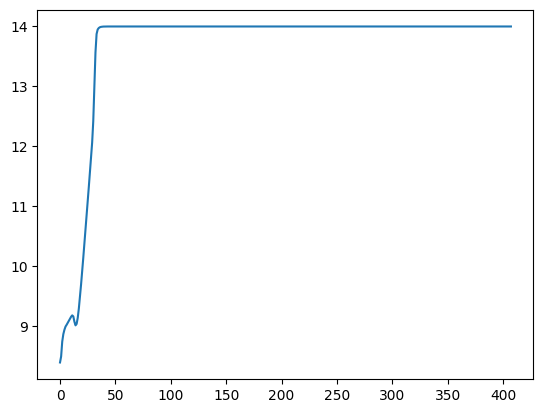

In [19]:
times = list(densities[0].keys())
in_densities = []
in_densities_2 = []
in_densities_3 = []
out_densities = []
in_densities_sum = []
out_densities_sum = []
tot_densities_sum = []
for t in times:
    try:
        in_densities.append(densities[2][t][0].detach().numpy())
        in_densities_2.append(densities[1][t][0].detach().numpy())
        in_densities_3.append(densities[5][t][0].detach().numpy())
        out_densities.append(densities[4][t][-2].detach().numpy())
        in_densities_sum.append(sum([d.detach().numpy() for d in densities[5][t]]))
        out_densities_sum.append(sum([d.detach().numpy() for d in densities[4][t]]))
        tot_densities_sum.append(sum([d.detach().numpy() for d in densities[4][t]]) + sum([d.detach().numpy() for d in densities[5][t]]))


    except:
        in_densities.append(densities[2][t][0])
        in_densities_2.append(densities[1][t][0])
        in_densities_3.append(densities[5][t][0])
        out_densities.append(densities[4][t][-2])
        in_densities_sum.append(sum([d for d in densities[5][t]]))
        out_densities_sum.append(sum([d for d in densities[4][t]]))
        tot_densities_sum.append(sum([d for d in densities[4][t]]) + sum([d for d in densities[5][t]]))



# print(in_densities)
# plt.plot(in_densities)
# plt.plot(in_densities_2)
# plt.plot(in_densities_3)
# plt.plot(out_densities)
# plt.plot(in_densities_sum)
# plt.plot(out_densities_sum)
plt.plot(tot_densities_sum)
plt.show()

In [29]:
print(densities[4])

{0: tensor([0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000,
        0.8000, 0.8000, 0.8000, 0.8000, 0.8000]), tensor(0.3273, grad_fn=<AddBackward0>): tensor([0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000,
        0.8000, 0.8000, 0.8000, 0.7100, 0.7100], grad_fn=<CopySlices>), tensor(0.6545, grad_fn=<AddBackward0>): tensor([0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000,
        0.8000, 0.7912, 0.7607, 0.6672, 0.6672], grad_fn=<CopySlices>), tensor(0.9818, grad_fn=<AddBackward0>): tensor([0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.7996,
        0.7957, 0.7701, 0.7228, 0.6408, 0.6408], grad_fn=<CopySlices>), tensor(1.3091, grad_fn=<AddBackward0>): tensor([0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.7997, 0.7971,
        0.7847, 0.7441, 0.6916, 0.6223, 0.6223], grad_fn=<CopySlices>), tensor(1.6364, grad_fn=<AddBackward0>): tensor([0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.

In [9]:
dfjkd

NameError: name 'dfjkd' is not defined

In [11]:
glgif.draw_timed_with_shift(network, densities, interval_seconds = 0.05)

End of simulation reached!
Saving GIF as: density_animation.gif


: 

In [ ]:
# Make animation: running it here makes the kernel die
# glutils.draw_timed_with_shift(network, densities, interval_seconds = 0.05)

#### Same network but with both crossing and right hand rule:

In [ ]:
# Creating the roads
L = 50
N = 5

road1 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (-1, 0), right_pos = (0, 0),
                initial = lambda x: torch.ones_like(x) * 0.8, inflow = 0.1, id = "1_fw")
road2 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (1, 0),
                initial = lambda x: torch.ones_like(x) * 0.2, inflow = 0.6, id = "2_fw")
road3 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (-1, 0),
                initial = lambda x: torch.ones_like(x) * 0.2, inflow = 0.6, id = "3_bw")
road4 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (1, 0), right_pos = (0, 0),
                initial = lambda x: torch.ones_like(x) * 0.8, inflow = 0.1, id = "4_bw")
road5 = rd.Road(1, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 1), right_pos = (0, 0),
                initial = lambda x: torch.ones_like(x) * 0.3, inflow = 0.05, id = "5")
road6 = rd.Road(1, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (0, -1),
                initial = lambda x: torch.ones_like(x) * 0.3, inflow = 0.3, id = "6")

roads = [road1, road2, road3, road4, road5, road6]
entering = [0, 3, 4]
leaving = [1, 2, 5]

In [ ]:
distribution = [[1.0, 0.0, 0.0],
                [0.0, 1.0, 0.0],
                [0.4, 0.4, 0.2]]

junction = jn.Junction(roads, entering=entering, leaving=leaving, distribution=distribution, trafficlights=[], 
                       coupled_trafficlights=[], duty_to_gw=True, priorities=priorities,
                       crossing_connections=crossing_connections)

In [ ]:
# Create the network and make simulation
T = 150
network = nw.RoadNetwork(roads, [junction], T)
densities, _, _, _ = network.solve_cons_law()

In [ ]:
glutils.draw_timed_with_shift(network, densities, interval_seconds = 0.05)

: 

In [ ]:
def short_stick_prob(x, d):
    '''
    Probability of a point x in [0,1] being hit by a stick of length d <= 0.5
    '''
    if x <= d:
        return x / (1 - d)
    elif x <= 1 - d:
        return d / (1 - d)
    else:
        return (1 - x) / (1 - d)
    
def long_stick_prob(x, d):
    '''
    Probability of a point x in [0,1] being hit by a stick of length d > 0.5
    '''
    if x <= 1 - d:
        return x / (1 - d)
    elif x <= d:
        return 1
    else:
        return (1 - x) / (1 - d)
    
def stick_prob(x,d):
    '''
    Probability of a point x in [0,1] being hit by a stick of length d (> 0)
    '''
    if d <= 0.5:
        return short_stick_prob(x,d)
    else:
        return long_stick_prob(x,d)
    
def two_short_explicit(d1, d2):
    '''
    Given two sticks of length d1 and d2, 0 < d1 <= d2 <= 0.5, 
    this function returns the explicit value of the integral
    int(0,1) 1 - p(x,d1) * p(x,d2) dx
    '''
    return 1 / ((1-d1)*(1-d2)) * (1/3*d1**3 + d1**2*d2 - d1**2 + 2*d1*d2**2 - 3*d1*d2 + d1 - d2**2 + d2)

def two_stick_quadrature(d1, d2):
    return integrate.quad(lambda x: 1 - (1-stick_prob(x,d1))*(1-stick_prob(x,d2)), 0, 1)

def n_stick_quadrature(d_list):
    '''
    all lengths in d in d_list should satisfy 0 < d < 1
    '''
    return integrate.quad(lambda x: 1 - np.prod([1-stick_prob(x,d) for d in d_list]), 0, 1)[0]